In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2) \
        * L(n,np.abs(m))(eta**2)

In [3]:
def hyperRamseyP(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega02, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0) 
    
    return pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def hyperRamseyM(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega02, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0) 
    
    return pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def HRerrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    RhoeeP = rhoee(hyperRamseyP(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02))
    RhoeeM = rhoee(hyperRamseyM(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02))
    return RhoeeP - RhoeeM

def HRThermP(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, nbar1, nbar2):
    intState = psi(0.0+0.0j, 0.0+0.0j)
    result = psi(0.0+0.0j, 0.0+0.0j)
    Ncut = 200
    eta = 0.01
    
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0) 
    
    for n in range(Ncut+1):
        pulse1 = pulse(t1, Omega01*Omega(n,0,eta), delPrime, 0.0, 0.0)
        intState += prob(n,nbar1)*pulse1@psi0

    intState2 = freeEvo@pi2PhaseInj@intState
    
    for n in range(Ncut+1):
        pulse2 = pulse(t2, Omega02*Omega(n,0,eta), delPrime, 0.0, 0.0)
        result += prob(n,nbar2)*pulse2@intState2
        
    return result

def HRThermM(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, nbar1, nbar2):
    intState = psi(0.0+0.0j, 0.0+0.0j)
    result = psi(0.0+0.0j, 0.0+0.0j)
    Ncut = 200
    eta = 0.01
    
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0) 
    
    for n in range(Ncut+1):
        pulse1 = pulse(t1, Omega01*Omega(n,0,eta), delPrime, 0.0, 0.0)
        intState += prob(n,nbar1)*pulse1@psi0

    intState2 = freeEvo@pi2PhaseInj@intState
    
    for n in range(Ncut+1):
        pulse2 = pulse(t2, Omega02*Omega(n,0,eta), delPrime, 0.0, 0.0)
        result += prob(n,nbar2)*pulse2@intState2
        
    return result

def HRThermErrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, nbar1, nbar2):
    RhoeeP = rhoee(HRThermP(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,nbar1,nbar2))
    RhoeeM = rhoee(HRThermM(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,nbar1,nbar2))
    return RhoeeP - RhoeeM

In [4]:
def hyperRamseyPhaseJumpM(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t2/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2/3.0, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    
    return pulse3@pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def hyperRamseyPhaseJumpP(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t2/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2/3.0, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    
    return pulse3@pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def HRJumperrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    RhoeeP = rhoee(hyperRamseyPhaseJumpP(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03))
    RhoeeM = rhoee(hyperRamseyPhaseJumpM(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03))
    return RhoeeP - RhoeeM

def HRJumpThermP(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3):
    result = psi(0.0+0.0j,0.0+0.0j)
    intState1 = psi(0.0+0.0j,0.0+0.0j)
    intState3 = psi(0.0+0.0j,0.0+0.0j)
    Ncut = 200
    eta = 0.01
    
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0) 
    
    for n in range(Ncut+1):
        pulse1 = pulse(t1, Omega01*Omega(n,0,eta), delPrime, 0.0, 0.0)
        intState1 += prob(n,nbar1)*pulse1@psi0
    
    intState2 = freeEvo@pi2PhaseInj@intState1
    
    for n in range(Ncut+1):
        pulse2 = pulse(2.0*t2/3.0, -Omega02*Omega(n,0,eta), delPrime, 0.0, 0.0)
        intState3 += prob(n,nbar2)*pulse2@intState2
            
    for n in range(Ncut+1):
        pulse3 = pulse(t2/3.0, Omega03*Omega(n,0,eta), delPrime, 0.0, 0.0)
        result += prob(n,nbar3)*pulse3@intState3
        
    return result

def HRJumpThermM(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3):
    result = psi(0.0+0.0j,0.0+0.0j)
    intState1 = psi(0.0+0.0j,0.0+0.0j)
    intState3 = psi(0.0+0.0j,0.0+0.0j)
    Ncut = 200
    eta = 0.01
    
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0) 
    
    for n in range(Ncut+1):
        pulse1 = pulse(t1, Omega01*Omega(n,0,eta), delPrime, 0.0, 0.0)
        intState1 += prob(n,nbar1)*pulse1@psi0
    
    intState2 = freeEvo@pi2PhaseInj@intState1
    
    for n in range(Ncut+1):
        pulse2 = pulse(2.0*t2/3.0, -Omega02*Omega(n,0,eta), delPrime, 0.0, 0.0)
        intState3 += prob(n,nbar2)*pulse2@intState2
            
    for n in range(Ncut+1):
        pulse3 = pulse(t2/3.0, Omega03*Omega(n,0,eta), delPrime, 0.0, 0.0)
        result += prob(n,nbar3)*pulse3@intState3
        
    return result

def HRThermJumperrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3):
    RhoeeP = rhoee(HRJumpThermP(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03,nbar1,nbar2,nbar3))
    RhoeeM = rhoee(HRJumpThermM(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03,nbar1,nbar2,nbar3))
    return RhoeeP - RhoeeM

In [5]:
def hyperRamseyPhaseJump2M(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    pulse1 = pulse(t1/3.0, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t1/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    
    return pulse3@freeEvo@pi2PhaseInj@pulse2@pulse1@psi0

def hyperRamseyPhaseJump2P(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    pulse1 = pulse(t1/3.0, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t1/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    
    return pulse3@freeEvo@pi2PhaseInj@pulse2@pulse1@psi0

def HRJump2errSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    RhoeeP = rhoee(hyperRamseyPhaseJump2P(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03))
    RhoeeM = rhoee(hyperRamseyPhaseJump2M(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03))
    return RhoeeP - RhoeeM

In [6]:
def HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, x1):
    return HRerrSig(psi0, t1, T, t2, x0, x0+Delta, Omega01, Omega02) * HRerrSig(psi0, t1, T, t2, x1, x1+Delta, Omega01, Omega02) < 0

def HRJumpvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, x0, x1):
    return HRJumperrSig(psi0,t1,T,t2,x0,x0+Delta,Omega01,Omega02,Omega03)*HRJumperrSig(psi0,t1,T,t2,x1,x1+Delta,Omega01,Omega02,Omega03) < 0

def HRThermJumpvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03,nbar1,nbar2,nbar3, x0, x1):
    return HRThermJumperrSig(psi0,t1,T,t2,x0,x0+Delta,Omega01,Omega02,Omega03,nbar1,nbar2,nbar3)*HRThermJumperrSig(psi0,t1,T,t2,x1,x1+Delta,Omega01,Omega02,Omega03,nbar1,nbar2,nbar3) < 0

def HRJump2validate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, x0, x1):
    return HRJump2errSig(psi0,t1,T,t2,x0,x0+Delta,Omega01,Omega02,Omega03)*HRJump2errSig(psi0,t1,T,t2,x1,x1+Delta,Omega01,Omega02,Omega03) < 0

def error_bound(a, b, err):
    n = np.log((b - a) / err) / np.log(2)
    return int(np.ceil(n))

def HRfindRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, guess):
    #x0 = guess - np.abs(guess)*0.025 - 0.015/Omega02
    #x1 = guess + np.abs(guess)*0.025 + 0.015/Omega02
    x0 = guess - 0.1
    x1 = guess + 0.1
    #print(x0,x1)
    
    if not HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRerrSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega01, Omega02)
        if -tol < y < tol:
            #print(Delta)
            return root_approx
        if HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1
        
def HRJumpfindRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, tol, guess):
    #x0 = -0.1*Delta/(Omega01*T) - 0.25*np.abs(2.0*Delta/(Omega01*T)) - 0.01
    #x1 = -0.1*Delta/(Omega01*T) + 0.25*np.abs(2.0*Delta/(Omega01*T)) + 0.01
    x0 = guess - 0.00005
    x1 = guess + 0.00005
    #print(x0,x1)
    
    if not HRJumpvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRJumperrSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega01, Omega02, Omega03)
        if -tol < y < tol:
            return root_approx
        if HRJumpvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1
        
def HRThermJumpfindRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3, tol, guess):
    #x0 = -0.1*Delta/(Omega01*T) - 0.25*np.abs(2.0*Delta/(Omega01*T)) - 0.01
    #x1 = -0.1*Delta/(Omega01*T) + 0.25*np.abs(2.0*Delta/(Omega01*T)) + 0.01
    x0 = guess - 0.00005
    x1 = guess + 0.00005
    #print(x0,x1)
    
    if not HRThermJumpvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRThermJumperrSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3)
        if -tol < y < tol:
            return root_approx
        if HRThermJumpvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1
        
def HRJump2findRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, tol, guess):
    #x0 = -0.1*Delta/(Omega03*T) - 1.25*np.abs(2.0*Delta/(Omega03*T)) - 0.01
    #x1 = -0.1*Delta/(Omega03*T) + 1.25*np.abs(2.0*Delta/(Omega03*T)) + 0.01
    x0 = guess - 0.000001
    x1 = guess + 0.000001
    #print(x0,x1)
    
    if not HRJump2validate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRJump2errSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega01, Omega02, Omega03)
        if -tol < y < tol:
            return root_approx
        if HRJump2validate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1

In [7]:
def HRHeatSensb(q, pulse1, pulse2, Delta):
    psi0 = psi(0.0, 1.0)
    t1 = 10.0e-3             #s
    t2 = t1*(pulse2/pulse1)
    Omega01 = pulse1/t1
    Omega02 = Omega01*q
    T = 10.0*t1
    
    tol = 1.0e-10
    shift = 0.0

    pts = 100
    Deltas = np.linspace(0.0, Delta*Omega01, pts)
    for ii in range(pts):
        shift = HRfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, Omega02, tol, shift)
        #print(shift)
        #print(Deltas[ii])
        
    if not isinstance(shift, float):
        return
    else:
        return shift
    
def HRJumpHeatSensb(q, Delta):
    psi0 = psi(0.0, 1.0)
    t1 = 10.0e-3
    T = 10*t1
    t2 = 3.0*t1
    Omega01 = np.pi/(2.0*t1)
    Omega02 = q*Omega01
    Omega03 = q*Omega01
    tol = 1.0e-10
    shift = 0.0

    pts = 100
    Deltas = np.linspace(0.0, Delta*Omega01, pts)
    for ii in range(pts):
        shift = HRJumpfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, Omega02, Omega03, tol, shift)
        #print(shift)
        
    if not isinstance(shift, float):
        return
    else:
        return shift
    
def HRThermJumpHeatSensb(nbar2, Delta):
    psi0 = psi(0.0, 1.0)
    t1 = 10.0e-3
    T = 10*t1
    t2 = 3.0*t1
    Omega01 = np.pi/(2.0*t1)
    Omega02 = Omega01
    Omega03 = Omega01
    nbar1 = 0.0
    nbar3 = nbar2
    tol = 1.0e-10
    shift = 0.0

    pts = 100
    Deltas = np.linspace(0.0, Delta*Omega01, pts)
    for ii in range(pts):
        shift = HRThermJumpfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, Omega02, Omega03, nbar1, nbar2, nbar3, tol, shift)
        #print(shift)
        
    if not isinstance(shift, float):
        return
    else:
        return shift
    
def HRJump2HeatSensb(q, Delta):
    psi0 = psi(0.0, 1.0)
    t1 = 3.0*10.0e-3
    T = 100.0e-3
    t2 = t1/3.0
    Omega01 = 3.0*np.pi/(2.0*t1)
    Omega02 = Omega01
    Omega03 = q*Omega01
    tol = 1.0e-10
    shift = 0.0

    pts = 100
    Deltas = np.linspace(0.0, Delta*Omega01, pts)
    for ii in range(pts):
        shift = HRJump2findRoot(psi0, t1, T, t2, Deltas[ii], Omega01, Omega02, Omega03, tol, shift)
       
    if not isinstance(shift, float):
        return
    else:
        return shift

In [8]:
pts = 51
qPts = np.linspace(0.7, 1.0, pts)
heatSensJ = np.zeros(pts,)
heatSensJ2 = np.zeros(pts,)
Delta = 0.00001

for ii in range(pts):
    heatSensJ[ii] = HRJumpHeatSensb(qPts[ii], Delta)
    heatSensJ2[ii] = HRJump2HeatSensb(qPts[ii], Delta)
    #print(qPts[ii])

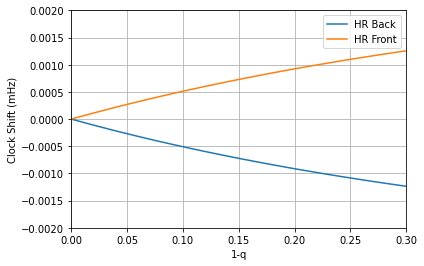

In [9]:
plt.plot(1-qPts, heatSensJ*100.0, label="HR Back")
plt.plot(1-qPts, heatSensJ2*100.0, label="HR Front")
plt.xlabel("1-q")
plt.ylabel("Clock Shift (mHz)")
plt.ylim([-.2e-2, .2e-2])
plt.xlim([0.0, 0.3])
plt.grid()
plt.legend()
plt.show()

In [ ]:
nbarpts=np.zeros(pts,)
heatSensJTherm = np.zeros(pts,)
Delta = 0.00001
for n in range(pts):
    nbarpts[n] = n
    heatSensJTherm[n] = HRThermJumpHeatSensb(n, Delta)

I want to make these pulse sequence functions work for thermal distribuitions. Let me try to recreate the decoherence phenomenon at the end of the Rabi rate calculation script with pulses.

In [14]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2) \
        * L(n,np.abs(m))(eta**2)

In [40]:
nbar = 10.0
Ncut = 200
eta = 0.1
ts = np.arange(0.0,50.0,0.2)
rhoDD = [0.0]*np.size(ts)
rhoDD2 = [0.0]*np.size(ts)
rhoDD3 = [0.0]*np.size(ts)
psi0 = psi(1.0,0.0)
for ii in range(np.size(ts)):
    for n in range(Ncut+1):
        rhoDD[ii] += prob(n,nbar)*rhoee(pulse(ts[ii], 2.0*Omega(n,0,eta), 1.0-Omega(n,0,eta), 0.0, 0.0)@psi0) #wrong
        rhoDD2[ii] += prob(n,nbar)*rhoee(pulse(ts[ii], 2.0*Omega(n,0,eta), 0.0, 0.0, 0.0)@psi0) #right
        rhoDD3[ii] += prob(n,nbar)*(np.sin(Omega(n,0,eta)*ts[ii]))**2

(0.44, 0.56)

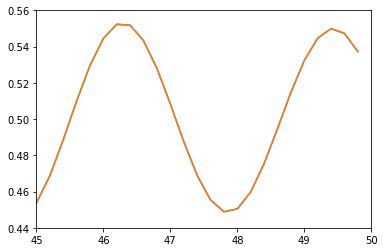

In [53]:
#plt.plot(ts,rhoDD)
plt.plot(ts,rhoDD2)
plt.plot(ts,rhoDD3)
plt.xlim([45,50])
plt.ylim([0.44,0.56])

In [160]:
t1 = 1.0
t2 = 3.0
T = 10.0
psi0 = psi(0.,1.0)
pts = 100
deltas = np.linspace(-0.1,0.1, pts)
rhoee1s = np.zeros(pts)
rhoee2s = np.zeros(pts)
Omega01 =1.0
Omega02 =1.0
nbar1 = 0.0
nbar2 = 0.0

for ii in range(pts):
    rhoee1s[ii] = rhoee(HRThermP(psi0, t1, T, t2, deltas[ii], deltas[ii], Omega01, Omega02, nbar1, nbar2))
    rhoee2s[ii] = rhoee(hyperRamseyP(psi0, t1, T, t2, deltas[ii], deltas[ii], Omega01, Omega02))

[0.02395114+0.47862349j 0.87289389-0.09166331j]
[0.02346806+0.47865555j 0.87308126-0.08981773j]
[0.02298494+0.47868696j 0.87326482-0.08797177j]
[0.02250178+0.47871772j 0.87344457-0.08612543j]
[0.02201856+0.47874782j 0.87362051-0.08427874j]
[0.0215353 +0.47877727j 0.87379264-0.08243169j]
[0.021052  +0.47880607j 0.87396094-0.08058429j]
[0.02056865+0.47883421j 0.87412544-0.07873654j]
[0.02008526+0.4788617j  0.87428612-0.07688847j]
[0.01960183+0.47888854j 0.87444298-0.07504007j]
[0.01911836+0.47891472j 0.87459602-0.07319136j]
[0.01863485+0.47894025j 0.87474525-0.07134233j]
[0.0181513 +0.47896513j 0.87489066-0.06949301j]
[0.01766771+0.47898935j 0.87503224-0.06764339j]
[0.01718409+0.47901292j 0.87517001-0.06579348j]
[0.01670043+0.47903583j 0.87530396-0.0639433j ]
[0.01621674+0.47905809j 0.87543409-0.06209284j]
[0.01573302+0.47907969j 0.8755604 -0.06024212j]
[0.01524926+0.47910064j 0.87568288-0.05839115j]
[0.01476547+0.47912094j 0.87580154-0.05653994j]
[0.01428165+0.47914058j 0.87591638-0.054

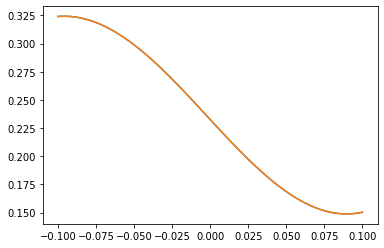

In [161]:
plt.plot(deltas, rhoee1s)
plt.plot(deltas, rhoee2s)

In [159]:
HRThermP(psi0, t1, T, t2, deltas[80], deltas[80], Omega01, Omega02, nbar1, nbar2)

[-0.01476547+0.47912094j  0.87580154+0.05653994j]


array([ 0.65073895+0.64621113j, -0.3935597 -0.063724j  ])

In [153]:
pulse(T, 0.0, deltas[80], 0.0, 0.0)@pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)@pulse(t1, Omega01, deltas[80], 0.0, 0.0)@psi0

array([-0.01476547+0.47912094j,  0.55227416-0.68206918j])

In [155]:
hyperRamseyP(psi0,t1,T,t2,deltas[80],deltas[80],Omega01,Omega02)

array([ 0.65073895+0.64621113j, -0.3935597 -0.063724j  ])

In [170]:
t1 = 1.0
t2 = 3.0
T = 10.0
psi0 = psi(0.,1.0)
pts = 100
deltas = np.linspace(-0.1,0.1, pts)
rhoee1s = np.zeros(pts)
rhoee2s = np.zeros(pts)
Omega01 =1.0
Omega02 =1.0
Omega03 =1.0
nbar1 = 0.0
nbar2 = 0.0
nbar3 = 0.0

for ii in range(pts):
    rhoee1s[ii] = rhoee(HRJumpThermP(psi0, t1, T, t2, deltas[ii], deltas[ii], Omega01, Omega02, Omega03, nbar1, nbar2, nbar3))
    rhoee2s[ii] = rhoee(hyperRamseyPhaseJumpP(psi0, t1, T, t2, deltas[ii], deltas[ii], Omega01, Omega02, Omega03))

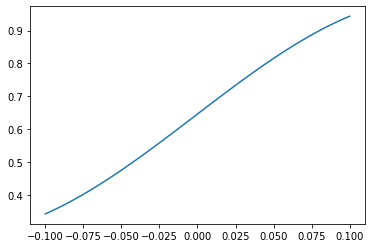

In [173]:
plt.plot(deltas, rhoee1s)
plt.plot(deltas, rhoee2s)

In [9]:
HRThermJumpHeatSensb(0.0, 0.00001)

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)


0.0